<a href="https://colab.research.google.com/github/michalszczecinski/data-driven-notebooks/blob/master/engineering/ic_measuring_characteristics_and_calibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Code Set Up

In [1]:
#@title Imports {display-mode: "form"}
import sys
import os
import platform
import random
import itertools
import math
import datetime

import numpy as np
import pandas as pd
from scipy import stats

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# reading google sheets files
import gspread
from oauth2client.client import GoogleCredentials

from collections import OrderedDict
from typing import List, Optional

In [2]:
# @title Dislay settings  {display-mode: "form"} 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
sns.set(context='notebook', style="whitegrid", rc={"figure.figsize": (20, 10)})
pd.set_option("display.float_format", '{:.3f}'.format)
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)
pd.set_option("max_colwidth", 200)

In [3]:
# @title Generate Report header with meta information {display-mode: "form"} 
def generate_header(author: Optional[str] = 'szczecinski',
                    title: Optional[str] = 'unknown',
                    description: Optional[str] = 'unknown',
                    prepared_for: Optional[str] = 'learning',
                    tags: Optional[List[str]] = [''],
                    links: Optional[List[str]] = ['']):
    """
    Generates standardised header with meta information describing the report.
    
    Args:
      author: Name of the author.
      title: Title of the report.
      description: Text describing the report.
      prepared_for: Text providing context and purpose of generating the report.
      tags: List of tags for searching.
      links: List of links for reference and cross linking.

    Returns:
      df_meta: Formatted Pandas Dataframe with meta information of the report.
    """
    meta_dict = OrderedDict()

    # Properties provided by author.
    meta_dict['author'] = author
    meta_dict['title'] = title
    meta_dict['description'] = description
    meta_dict['prepared_for'] = prepared_for
    meta_dict['tags'] = str(tags)
    meta_dict['links'] = str(links)

    # Properties auto generated by the system.
    runtime = datetime.datetime
    meta_dict['runtime'] = runtime.now().strftime("%Y-%m-%d %H:%M:%S")
    path = os.getcwd()
    meta_dict['path'] = path
    python_version = platform.python_version()
    meta_dict['python_version'] = python_version
    meta_dict['pandas_version'] = pd.__version__

    df_meta= pd.DataFrame(meta_dict, index=['report_information']).T
    return df_meta

<a name="cell-header"></a>
# Instrumentation and Control - Measuring Characteristics and Calibration - Example

[Link to this Colab](https://colab.research.google.com/drive/1Dw5YRUEtRxS6rPPAldqS2FIowT-MA_Sp?usp=sharing)

In [4]:
# setting up header info
author = 'Michal Szczecinski'
prepared_for ='Instrumentation and Control - Assignment Tutorial 2'
title = 'Measuring Characteristics and Calibration - Tutorial Assignment 2'
description = 'Notebook for solving a typical calibration problem and serving as a reference for measuring and calibration.'
tags = ['#instrumentation', '#control', '#measurement', '#calibration', "#mechatronics"]
links = ['']
generate_header(author=author,
                title=title,
                description=description,
                prepared_for=prepared_for,
                tags=tags,
                links=links)

,report_information
author,Michal Szczecinski
title,Measuring Characteristics and Calibration - Tutorial Assignment 2
description,Notebook for solving a typical calibration problem and serving as a reference for measuring and calibration.
prepared_for,Instrumentation and Control - Assignment Tutorial 2
tags,"['#instrumentation', '#control', '#measurement', '#calibration', '#mechatronics']"
links,['']
runtime,2021-12-13 13:19:51
path,/content
python_version,3.7.12
pandas_version,1.1.5


## Context

## Configuration

# Calibration exercise

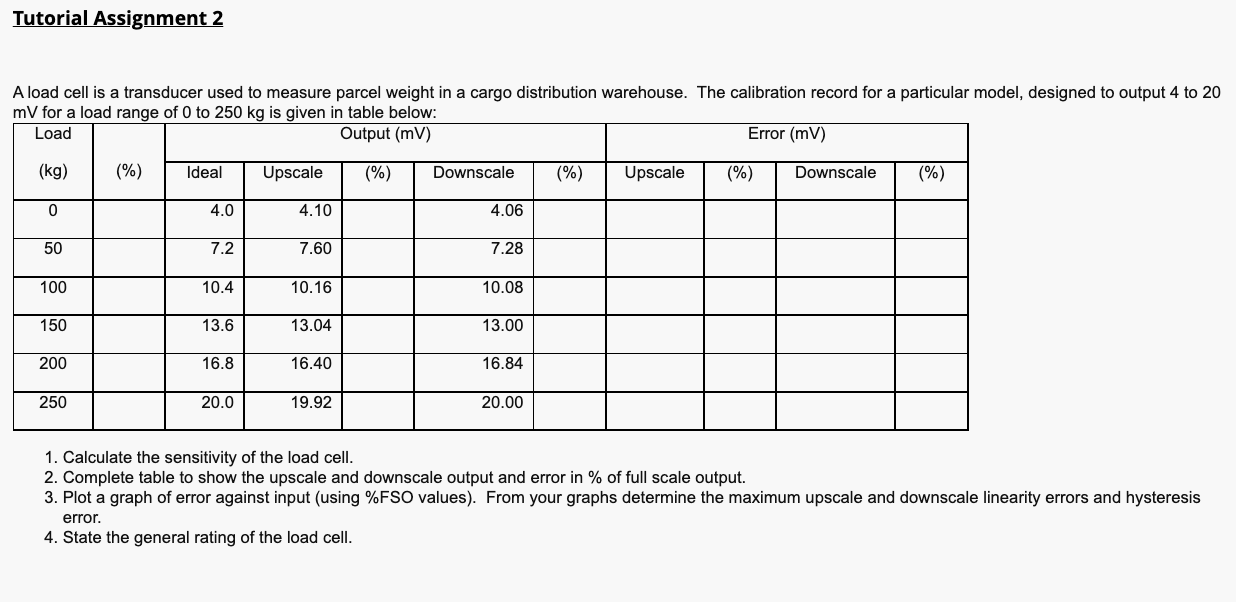

In [5]:
input = [0,50,100,150,200,250]
output_ideal = [4,7.2,10.4,13.6, 16.8,20]
output_upscale = [4.10,7.60, 10.16,13.04, 16.40, 19.92]
output_downscale = [4.06, 7.28, 10.08, 13.00, 16.84, 20.00]

data = {'input': input,
        'output_ideal': output_ideal,
        'output_upscale': output_upscale,
        'output_downscale':output_downscale}
df = pd.DataFrame(data)
df

,input,output_ideal,output_upscale,output_downscale
0,0,4.000,4.100,4.060
1,50,7.200,7.600,7.280
2,100,10.400,10.160,10.080
3,150,13.600,13.040,13.000
4,200,16.800,16.400,16.840
5,250,20.000,19.920,20.000


In [7]:
# input
input_initial_value = df['input'][0]
input_span = df['input'].max() - df['input'].min()

# output_ideal
output_initial_value = df['output_ideal'][0]
output_ideal_span = df['output_ideal'].max() - df['output_ideal'].min()

#output upscale
output_upscale_initial_value = df['output_upscale'][0]
output_upscale_span = df['output_upscale'].max() - df['output_upscale'].min()

#output downscale
output_downscale_initial_value = df['output_downscale'][0]
output_downscale_span = df['output_downscale'].max() - df['output_downscale'].min()

df_support_data = pd.DataFrame({'input_initial_value': input_initial_value,
                   'input_span': input_span,
                   'output_initial_value': output_initial_value,
                   'output_span': output_ideal_span,
                   'output_upscale_initial_value': output_upscale_initial_value,
                   'output_upscale_span': output_upscale_span,
                   'output_downscale_initial_value': output_downscale_initial_value,
                   'output_downscale_span': output_downscale_span
                   }, index=['values'])
df_support_data.T

,values
input_initial_value,0.000
input_span,250.000
output_initial_value,4.000
output_span,16.000
output_upscale_initial_value,4.100
output_upscale_span,15.820
output_downscale_initial_value,4.060
output_downscale_span,15.940


## 1) Calculate sensitivity of the load cell.

In [9]:
sensitivy = output_ideal_span/input_span
sensitivy

0.064

## 2) Complete table to show the upscale and downscale output and error in % of full scale output.

In [11]:
# finding common factor - calculate percentage columns
df['input_pct'] = (df['input']-input_initial_value)/input_span * 100
df['output_ideal_pct'] = (df['output_ideal']-output_initial_value)/output_ideal_span * 100
df['output_upscale_pct'] = (df['output_upscale']-output_upscale_initial_value)/output_upscale_span * 100
df['output_downscale_pct'] = (df['output_downscale']-output_downscale_initial_value)/output_downscale_span * 100
df.loc[:, df.columns.str.endswith('pct')]

,input_pct,output_ideal_pct,output_upscale_pct,output_downscale_pct
0,0.000,0.000,0.000,0.000
1,20.000,20.000,22.124,20.201
2,40.000,40.000,38.306,37.767
3,60.000,60.000,56.511,56.085
4,80.000,80.000,77.750,80.176
5,100.000,100.000,100.000,100.000


In [12]:
# calculate errors
df['error_upscale'] = df['output_upscale']  - df['output_ideal']
df['error_downscale'] = df['output_downscale']  - df['output_ideal']
df['error_upscale_pct'] = df['output_upscale_pct']  - df['output_ideal_pct']
df['error_downscale_pct'] = df['output_downscale_pct']  - df['output_ideal_pct']
df_errors = df.loc[:, df.columns.str.startswith('error')]
df_errors

,error_upscale,error_downscale,error_upscale_pct,error_downscale_pct
0,0.100,0.060,0.000,0.000
1,0.400,0.080,2.124,0.201
2,-0.240,-0.320,-1.694,-2.233
3,-0.560,-0.600,-3.489,-3.915
4,-0.400,0.040,-2.250,0.176
5,-0.080,0.000,0.000,0.000


## 3) Plot a graph of errors

Plot a graph of error against input (using %FSO values).  From your graphs determine the maximum upscale and downscale linearity errors and hysteresis error.


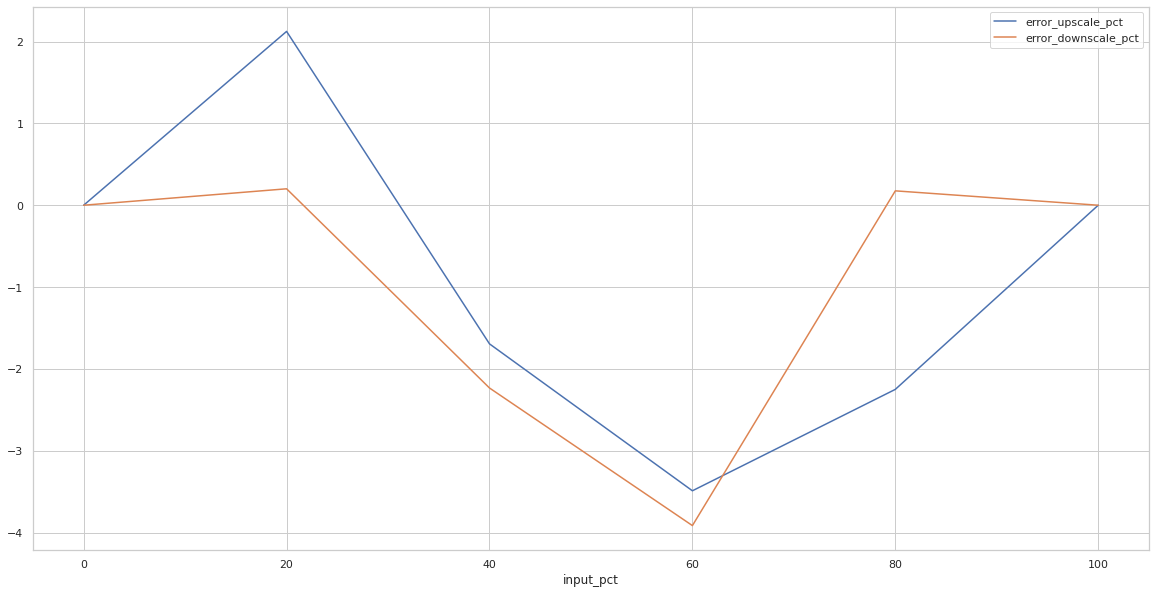

In [13]:
cols = ['input_pct', 'error_upscale_pct','error_downscale_pct']
df[cols].set_index('input_pct').plot();

### Error summary statistics (including min and max)

In [14]:
df_error_summary = df_errors.describe()
df_error_summary

,error_upscale,error_downscale,error_upscale_pct,error_downscale_pct
count,6.000,6.000,6.000,6.000
mean,-0.130,-0.123,-0.885,-0.962
std,0.348,0.277,1.996,1.722
min,-0.560,-0.600,-3.489,-3.915
25%,-0.360,-0.240,-2.111,-1.675
50%,-0.160,0.020,-0.847,0.000
75%,0.055,0.055,0.000,0.132
max,0.400,0.080,2.124,0.201


In [15]:
df_error_summary.loc[['max','min'], ['error_upscale_pct','error_downscale_pct']]

,error_upscale_pct,error_downscale_pct
max,2.124,0.201
min,-3.489,-3.915


### Hysteresis
Hysteresis error is the maximum difference in error between the coresponding `Upscale Graph` and the `Downscale Graph` readings at the same input `percentage` (for a full cycle transversal). It is expressed as the `% Error` and the `Input %` percentage that this occurs.


In [16]:
# hysteresis values
df['hysteresis_pct_diff'] = df['output_upscale_pct'] - df['output_downscale_pct']
df['hysteresis_pct_abs'] = np.absolute(df['hysteresis_pct_diff'])
cols =['input_pct', 'output_upscale', 'output_downscale','hysteresis_pct_diff','hysteresis_pct_abs']
df[cols]

,input_pct,output_upscale,output_downscale,hysteresis_pct_diff,hysteresis_pct_abs
0,0.000,4.100,4.060,0.000,0.000
1,20.000,7.600,7.280,1.923,1.923
2,40.000,10.160,10.080,0.539,0.539
3,60.000,13.040,13.000,0.425,0.425
4,80.000,16.400,16.840,-2.426,2.426
5,100.000,19.920,20.000,0.000,0.000


### Hysteresis error

In [17]:
hysteresis_error_ix = df['hysteresis_pct_abs'].idxmax()
df[['input_pct','hysteresis_pct_abs']].loc[hysteresis_error_ix]

input_pct            80.000
hysteresis_pct_abs    2.426
Name: 4, dtype: float64

### Linearity Errors


The most common types of linearity are independent linearity, terminal-based linearity, zero-based linearity, and least-squares linearity. The least-squares fit is the most sophisticated method, involving considerable computation, which is usually done on a computer. The least-squares line minimizes the sum of the squares of the deviations. 

Since we are using computer for calibration and in Python it is simply a one line of code, I chose this method for the best accuracy.


### Output upscale linearity errors

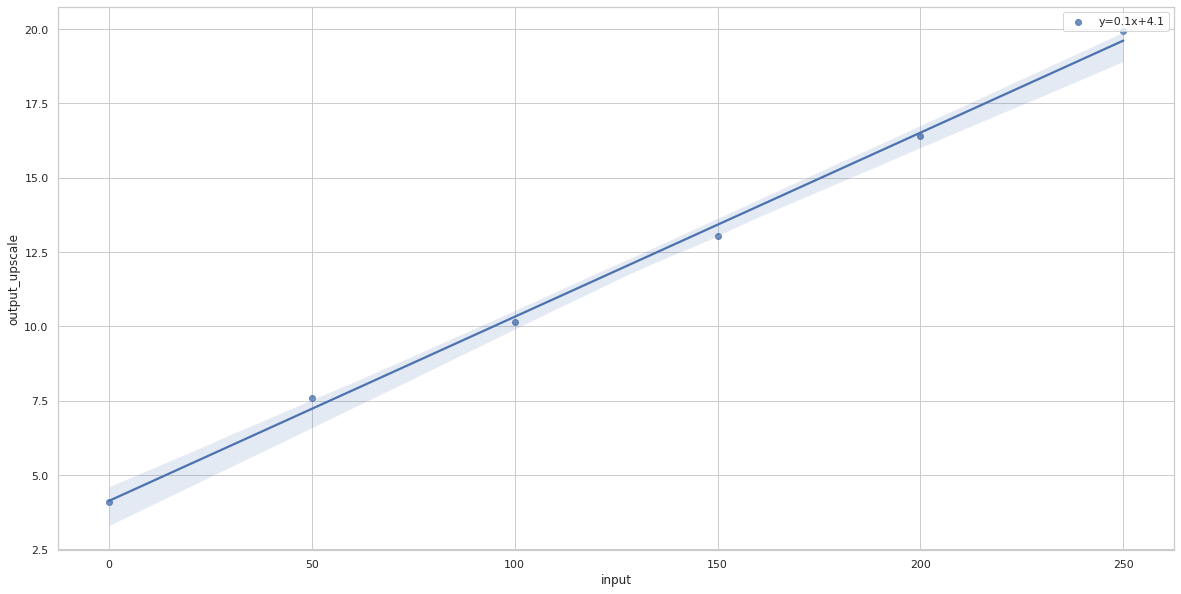

In [18]:
slope, intercept, r_value, pv, se = stats.linregress(df['input'],df['output_upscale'])
ax = sns.regplot(x="input", y="output_upscale", data=df, label="y={0:.1f}x+{1:.1f}".format(slope, intercept)).legend(loc="best")

In [19]:
df['output_upscale_linearity'] = df['input'] * slope + intercept
df['output_upscale_linear_error'] = df['output_upscale_linearity'] - df['output_ideal']
df['output_upscale_linear_error_pct_span'] = (df['output_upscale_linear_error'] / output_ideal_span)*100
cols = df.loc[:, df.columns.str.startswith('output_upscale_linear')].columns
cols = ['output_ideal','output_upscale'] + list(cols)
df[cols]

,output_ideal,output_upscale,output_upscale_linearity,output_upscale_linear_error,output_upscale_linear_error_pct_span
0,4.000,4.100,4.129,0.129,0.804
1,7.200,7.600,7.225,0.025,0.157
2,10.400,10.160,10.322,-0.078,-0.489
3,13.600,13.040,13.418,-0.182,-1.136
4,16.800,16.400,16.515,-0.285,-1.782
5,20.000,19.920,19.611,-0.389,-2.429


### Output upscale linearity errors

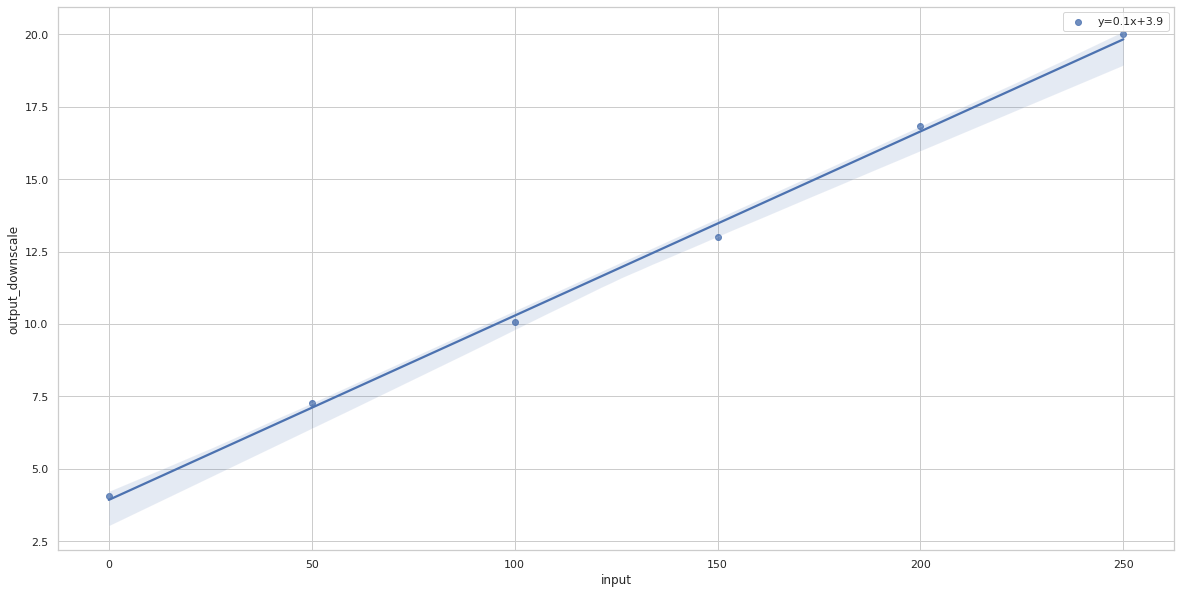

In [20]:
slope, intercept, r_value, pv, se = stats.linregress(df['input'],df['output_downscale'])
ax = sns.regplot(x="input", y="output_downscale", data=df, label="y={0:.1f}x+{1:.1f}".format(slope, intercept)).legend(loc="best")

In [21]:
df['output_downscale_linearity'] = df['input'] * slope + intercept
df['output_downscale_linear_error'] = df['output_downscale_linearity'] - df['output_ideal']
df['output_downscale_linear_error_pct_span'] = (df['output_downscale_linear_error'] / output_ideal_span)*100
cols = df.loc[:, df.columns.str.startswith('output_downscale_linear')].columns
cols = ['output_ideal','output_downscale'] + list(cols)
df[cols]

,output_ideal,output_downscale,output_downscale_linearity,output_downscale_linear_error,output_downscale_linear_error_pct_span
0,4.000,4.060,3.927,-0.073,-0.458
1,7.200,7.280,7.107,-0.093,-0.583
2,10.400,10.080,10.287,-0.113,-0.708
3,13.600,13.000,13.467,-0.133,-0.833
4,16.800,16.840,16.647,-0.153,-0.958
5,20.000,20.000,19.827,-0.173,-1.083


## 4) State the general rating of the load cell.

`General Rating` is also expressed in two parts - the lower range limit and the upper range limit as well as the maximum error from the calibration graph expressed as $\pm$ % (worst case scenario). We are saying that this sensor is rated to be able to measure load within certain range. 



In [22]:
input_lower_range_limit =  df['input'].min()
input_upper_range_limit =  df['input'].max()
output_ideal_lower_range_limit =  df['output_ideal'].min()
output_ideal_upper_range_limit =  df['output_ideal'].max()

In [23]:
# calculating the maximum absolute error
# all_errors = list(df['error_upscale_pct']) + list(df['error_downscale_pct'])
all_errors = np.concatenate((df['error_upscale_pct'].values, df['error_downscale_pct'].values), axis=None)
absolute_errors = np.absolute(all_errors)
largest_abs_error = round(absolute_errors.max(),3)
largest_abs_error

3.915

In [24]:
print (f'General Rating is ({input_lower_range_limit}-{input_upper_range_limit}) kg +/- {largest_abs_error} %')

General Rating is (0-250) kg +/- 3.915 %


## (BONUS) Other Statistics

### Resolution
The resolution is the smallest single step change in output. Resolution is usually expressed as a percent of the output span of the instrument.

Average resolution = 100/N (%)

Where N is the number of discrete output steps. 

In [25]:
average_resolution_pct = 100/len(df['output_ideal'])
average_resolution_pct

16.666666666666668

In [26]:
# TODO: Expand the problem by adding additional metrics and cycles (using random noise). 

## References

Introduction to Control System Technology, Robert M. Bateson

In [28]:
# @title Converting and exporting output {display-mode: "form"} 
# uncomment sections one at a time

# installs for converting to pdf
# !apt-get install texlive texlive-xetex texlive-latex-extra pandoc
# !pip install pypandoc

# mount drive to access .ipynb file
# from google.colab import drive
# drive.mount('/content/drive')

# covert and export output 
!cp 'drive/My Drive/Colab Notebooks/ic_measuring_characteristics_and_calibration.ipynb' ./
!jupyter nbconvert --to HTML "ic_measuring_characteristics_and_calibration.ipynb"

[NbConvertApp] Converting notebook ic_measuring_characteristics_and_calibration.ipynb to HTML
[NbConvertApp] Writing 639688 bytes to ic_measuring_characteristics_and_calibration.html
